In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, ICRS
from astropy import units as u
from modules.velocity_transformations import equatorial_UVW
from modules.vr_opt import VrOpt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
import hdbscan

In [172]:
import stag.graph
import math

def fast_spectral_cluster(g: stag.graph.Graph, k: int, t_mult: int = 10) -> np.ndarray:
    """Implementation see: https://github.com/pmacg/fast-spectral-clustering/tree/main"""
    l = min(k, math.ceil(math.log(k, 2)))
    t = t_mult * math.ceil(math.log(g.number_of_vertices() / k, 2))
    M = g.normalised_signless_laplacian()
    Y = np.random.normal(size=(g.number_of_vertices(), l))

    # We know the top eigenvector of the normalised laplacian.
    # It doesn't help with clustering, so we will project our power method to
    # be orthogonal to it.
    top_eigvec = np.sqrt(g.degree_matrix().to_scipy() @ np.full((g.number_of_vertices(),), 1))
    norm = np.linalg.norm(top_eigvec)
    if norm > 0:
        top_eigvec /= norm

    for _ in range(t):
        Y = M @ Y

        # Project Y to be orthogonal to the top eigenvector
        for i in range(l):
            Y[:, i] -= (top_eigvec.transpose() @ Y[:, i]) * top_eigvec

    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(Y)
    return kmeans.labels_

# Idea

TODO:
1. Create graph over data (e.g. kNN graph)
2. Compute pairwise velocity differences for all pairs connected by an edge (already supported by VrOpt)
3. Cut graph using velocity differences (maximal velocity difference)
4. Remaining connected components are "complete linkage" clusters
5. Take remaining connected components and cluster them in XYZ space using SigMA


In [3]:
# Plotting related stuff
alphas = [0.9, 0.9, 0.3]
colors = ['tab:red', 'tab:blue', 'tab:grey']
zorders = [1, 1, 0]
log = True

In [14]:
# Create 6D Gaussian data
n = 50_000
n_clusters = 500
X_bg = (np.random.rand(n, 6) - 0.5) * 100

mu = np.array([-5, 5, 5, 5, -5, 5])
c_xx = c_yy = 20
c_xy = 15
c_zz = 3
c_uvw = 1
cov = np.diag([c_xx, c_yy, c_zz, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy
# Add signal
X_sig_1 = np.random.multivariate_normal(mu, cov, n_clusters)

# Second cluster
mu_2 = np.array([5, -5, -5, -5, 5, -5])
c_xx_2 = c_yy = 20
c_xy_2 = -15
c_zz_2 = 3
cov = np.diag([c_xx_2, c_yy, c_zz_2, c_uvw, c_uvw, c_uvw])
# Put in nonzero covariances in X-Y space
cov[0, 1] = cov[1, 0] = c_xy_2
X_sig_2 = np.random.multivariate_normal(mu_2, cov, n_clusters)

X = np.concatenate([X_bg, X_sig_1, X_sig_2], axis=0)
labels = np.concatenate([np.zeros(n), np.ones(n_clusters), np.ones(n_clusters)*2]) -1

df = pd.DataFrame(X, columns=['x', 'y', 'z', 'vx', 'vy', 'vz'])
# Transform to spherical coordinates
gal_coords = Galactic(
    u=df.x.values * u.pc,
    v=df.y.values * u.pc,
    w=df.z.values * u.pc,
    # velocities UVW
    U=df.vx.values * u.km / u.s,
    V=df.vy.values * u.km / u.s,
    W=df.vz.values * u.km / u.s,
    representation_type="cartesian",
    # Velocity representation
    differential_type="cartesian",
)
# transform to ICRS
icrs_coords = gal_coords.transform_to(ICRS())
icrs_coords.representation_type = "spherical"

ra = icrs_coords.ra.value
dec = icrs_coords.dec.value
dist = icrs_coords.distance.value
pmra = icrs_coords.pm_ra.value * np.cos(np.deg2rad(dec))
pmdec = icrs_coords.pm_dec.value
rv_calc = icrs_coords.radial_velocity.value

df['ra'] = ra
df['dec'] = dec
df['dist'] = dist
df['pmra'] = pmra
df['pmdec'] = pmdec
df['radial_velocity'] = rv_calc

df['vt_ra'] = df.pmra * df.dist * 4.74
df['vt_dec'] = df.pmdec * df.dist * 4.74

idx_cluster_1 = np.where(labels==0)[0]
idx_cluster_2 = np.where(labels==1)[0]
idx_bg = np.where(labels==-1)[0]

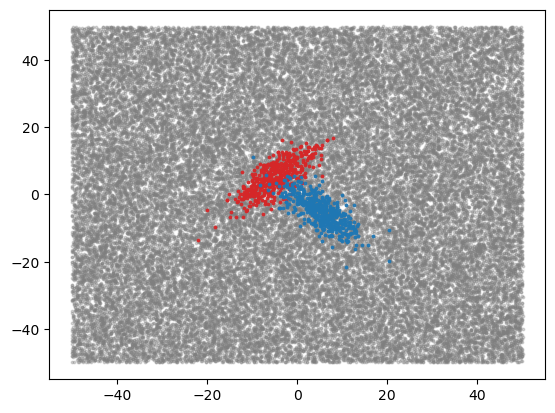

In [15]:
x_col, y_col = 'x', 'y'
# x_col, y_col = 'vx', 'vy'
# x_col, y_col = 'vt_ra', 'vt_dec'
# x_col, y_col = 'pmra', 'pmdec'
for idx_sel, alpha, c, zo in zip([idx_cluster_1, idx_cluster_2, idx_bg], alphas, colors, zorders): 
    plt.scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, c=c, alpha=alpha, zorder=zo)

In [124]:
# Find knn in 3D space
knn = 1_000

X = df[['x', 'y', 'z']].values
# neigh = NearestNeighbors(n_neighbors=knn, n_jobs=-1).fit(X)
# idx_neighbors = neigh.kneighbors(X, knn, return_distance=False)
A = kneighbors_graph(X, knn, mode='connectivity', n_jobs=-1)
# Symmetrize the matrix
A = A + A.T

In [125]:
# Get lower triangular part
row, col = A.nonzero()

# Filter indices for lower triangular part (including diagonal)
mask = row > col

# Get the lower triangular non-zero indices
r_low, c_low = np.vstack((row[mask], col[mask]))

# Compute pairwise velocity differences

In [126]:
est = VrOpt(ra, dec, pmra, pmdec, dist)
rv_i, rv_j, delta_v_opt = est.vr_opt(r_low, c_low)

In [158]:
# Min max rv
# max_abs_rv = 200
# rel_rv_est = (np.abs(rv_i) < max_abs_rv) & (np.abs(rv_j) < max_abs_rv)
# Set unrealistic values to inf
# delta_v_opt[unrealistic_rv_est] = np.inf

# Create pairwise distance matrix with delta_v entries
# dist_v_opt = csr_matrix((delta_v_opt[rel_rv_est], (r_low[rel_rv_est], c_low[rel_rv_est])), shape=A.shape)
dist_v_opt = csr_matrix((delta_v_opt, (r_low, c_low)), shape=A.shape)
# Make sure the matrix is symmetric
dist_v_opt = dist_v_opt + dist_v_opt.T

In [173]:
estimator = NearestNeighbors(n_neighbors=100, n_jobs=-1, metric="precomputed").fit(dist_v_opt)
connectivity = estimator.kneighbors_graph(X=dist_v_opt, mode="connectivity")
affinity_matrix_ = 0.5 * (connectivity + connectivity.T)
G = stag.graph.Graph(affinity_matrix_)

/Users/ratzenboe/anaconda3/lib/python3.11/site-packages/sklearn/neighbors/_base.py:232: EfficiencyWarning: Precomputed sparse input was not sorted by row values. Use the function sklearn.neighbors.sort_graph_by_row_values to sort the input by row values, with warn_when_not_sorted=False to remove this warning.
  warnings.warn(


In [188]:
k = 4
labels_sp_cl = fast_spectral_cluster(G, k, t_mult=10)

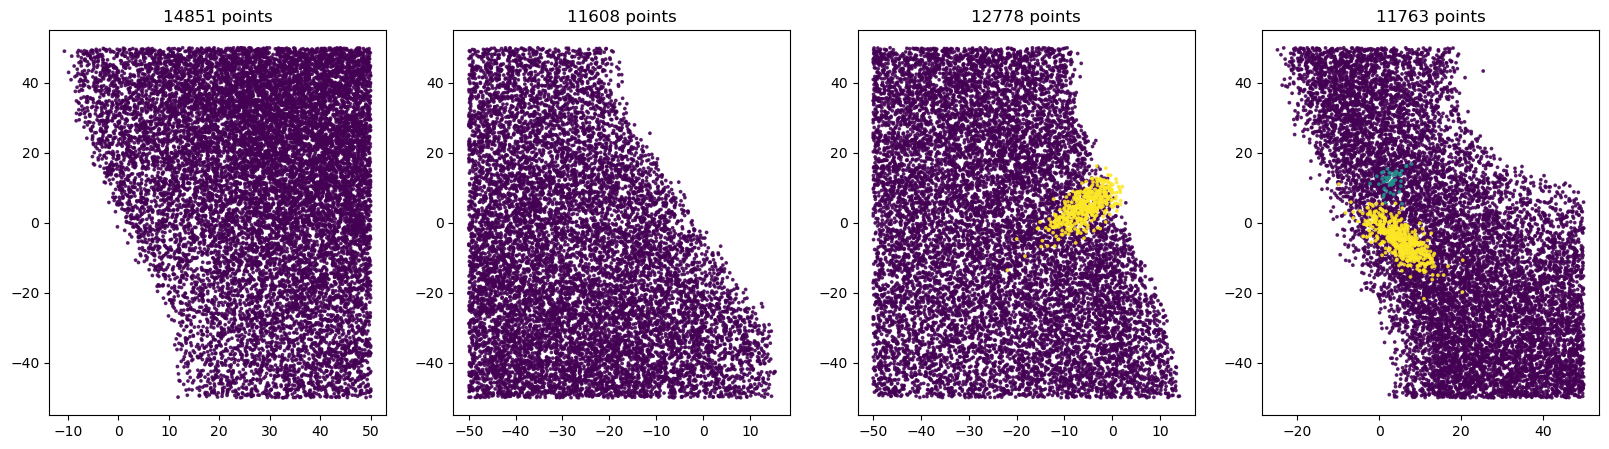

In [189]:
# x_col, y_col = 'vt_ra', 'vt_dec'
x_col, y_col = 'x', 'y'
# x_col, y_col = 'pmra', 'pmdec'

fig, ax = plt.subplots(1, k, figsize=(5*k, 5))
for l_i in np.unique(labels_sp_cl):
    if l_i != -1:
        idx_sel = labels_sp_cl == l_i
        ax[l_i].scatter(df.loc[idx_sel, x_col], df.loc[idx_sel, y_col], s=3, alpha=0.8, zorder=1, c=labels[idx_sel])
        ax[l_i].set_title(f'{np.sum(idx_sel)} points')
        
# plt.scatter(df.loc[labels_spectral==-1, x_col], df.loc[labels_spectral==-1, y_col], s=3, alpha=0.2, c='tab:grey', zorder=0)